In [356]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy.stats import entropy
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter

In [223]:
k_neighbors = 50
knn_clusters = 50
keep_k_evecs = 10
drop_k_evecs=2

cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")

icd_to_phecode = pd.read_csv("./phecode_icd9_map_unrolled.csv")
phecode_definitions = pd.read_csv("./phecode_definitions.csv")

A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

In [343]:
cluster_assignments["CLUSTER"].max()

49

In [10]:
icd9codes

,ICD9_CODE
0,0030
1,0031
2,0038
3,0039
4,0041
...,...
6979,V902
6980,V9039
6981,V9081
6982,V9089


In [19]:
icd9codes_asarray = icd9codes["ICD9_CODE"].tolist()
len(icd9codes_asarray)

6984

In [35]:
icd9diag

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


In [6]:
def cluster_size_quartiles(cluster_labels): 
    cluster_label_counts = Counter(cluster_labels).items()
    cluster_labels = [p[0] for p in cluster_label_counts]
    cluster_sizes = [p[1] for p in cluster_label_counts]
    return (np.quantile(cluster_sizes, 0.25), np.quantile(cluster_sizes, 0.75))

y_cluster_quartiles = cluster_size_quartiles(Y_cluster_labels)
y_mc_cluster_quartiles = cluster_size_quartiles(Y_mc_cluster_labels)

print(y_cluster_quartiles, y_mc_cluster_quartiles)

(423.75, 1151.75) (345.5, 1143.5)


In [220]:
#Current scatter plot plots top 3 diseases _ cluster index _ cluster size
#Clusters of interest in order from most to least promising: 
#small = (43, 21, 34)
#medium = (10, 38)
#large = (9, 35)
#NOTE: We want to do a comparison internally across cluster sizes and externally. 
#This means you want to show that small clusters capture diferent things from eachother, repeat with med and lg
#THEN do a comparison across the sizes
#Select the top 10 ICD9 Codes for brevity

def top_cluster_feats(cluster_i, n_top_feats=10):
    #Get features in cluster
    pidx_in_cluster_i = cluster_assignments[cluster_assignments["CLUSTER"] == cluster_i]['ORIGINAL_INDEX']
    pfeats_in_cluster_i = patient_icd_binary[pidx_in_cluster_i]

    #Sum them up to find most common ICD codes
    pfeats_distr_in_cluster_i = np.asarray(pfeats_in_cluster_i.sum(axis=0))

    icd9codes_aslist = icd9codes["ICD9_CODE"].tolist()

    icd_freq_pairs_in_cluster_i = list(zip(icd9codes_aslist, pfeats_distr_in_cluster_i[0]))
    icd_freq_pairs_in_cluster_i = sorted(icd_freq_pairs_in_cluster_i, key=lambda p: p[1], reverse=True)
    print(icd_freq_pairs_in_cluster_i)
    #Use only the top n ICD9 codes
    top_icds_freqs_in_cluster_i = icd_freq_pairs_in_cluster_i[:n_top_feats]
    top_icds_in_cluster_i = [p[0] for p in top_icds_freqs_in_cluster_i]
    top_freqs_in_cluster_i = [p[1] for p in top_icds_freqs_in_cluster_i]

    #NOTE total_feats_in_cluster_i is NOT equal to the number of members in a cluster
    sum_top_feats_in_cluster_i = np.sum(top_freqs_in_cluster_i)

    top_icd_percent_occurence_in_cluster_i = [float(f)/sum_top_feats_in_cluster_i for f in top_freqs_in_cluster_i]

    top_icd9_titles = []
    for icd in top_icds_in_cluster_i:
        try:
            long_title = icd9diag[icd9diag['ICD9_CODE'] == icd]["LONG_TITLE"].values[0]
            top_icd9_titles.append(long_title)
        except:
            print("No data found for ICD code {}".format(icd))
            pass

    icd_title_strs_in_cluster_i = ["icd:{}_{}".format(top_icds_in_cluster_i[p], top_icd9_titles[p]) for p in range(n_top_feats)]
    top_feats_in_cluster_i_dict = {"CLUSTER": [cluster_i] * n_top_feats, 
                                   "ICD9_CODE": top_icds_in_cluster_i, 
                                   "ICD9_FREQS": top_freqs_in_cluster_i,
                                   "ICD9_PERCENTAGE": top_icd_percent_occurence_in_cluster_i, 
                                   "LONG_TITLE": top_icd9_titles, 
                                   "ICD_TITLE": icd_title_strs_in_cluster_i}

    top_feats_in_cluster_i_df = pd.DataFrame(top_feats_in_cluster_i_dict)
    return top_feats_in_cluster_i_df

def feats_for_clusters(specific_clusters_of_interest):
    cluster_dfs = []
    for ci in specific_clusters_of_interest:
        ci_df = top_cluster_feats(ci, 5)
        cluster_dfs.append(ci_df)

    cluster_dfs = pd.concat(cluster_dfs)
    unique_icd9codes = pd.unique(cluster_dfs["ICD9_CODE"])
    icd_idx_mapping = {k: v for v, k in enumerate(unique_icd9codes)}
    
    icd_to_icd_title_mapping = {}
    for icd in unique_icd9codes:
        icd_title = cluster_dfs[cluster_dfs["ICD9_CODE"] == icd]["ICD_TITLE"].values[0]
        icd_to_icd_title_mapping[icd] = icd_title
        
    percentage_dfs = []
#     ci = specific_clusters_of_interest[0]
    for ci in specific_clusters_of_interest:
        percentage_vec = np.zeros(len(icd_idx_mapping))

        c_df = cluster_dfs[cluster_dfs["CLUSTER"] == ci]
        c_icds = c_df["ICD9_CODE"].tolist()
        c_percentages = c_df["ICD9_PERCENTAGE"].tolist()

        #Populate the percentage vector with values
        for i, icd in enumerate(c_icds):
            icd_idx = icd_idx_mapping[icd]
            percentage_vec[icd_idx] = c_percentages[i]

        #Use percentage vector to build a dataframe row    
        icd_percentage_pairs = []
        for icd, icd_idx in icd_idx_mapping.items():
            icd_title = icd_to_icd_title_mapping[icd]
            percentage = percentage_vec[icd_idx]
            icd_percentage_pairs.append((icd_title, percentage))
            
        cluster_feat_row = dict(icd_percentage_pairs)
        cluster_feat_row["CLUSTER"] = "C{}".format(ci)
        cluster_percentages_df = pd.DataFrame([cluster_feat_row])
        percentage_dfs.append(cluster_percentages_df)
        
    return pd.concat(percentage_dfs)
   
#Visualize top ICDs => make sure ~5-10 are highly enriched
def heatmap_clusters(cluster_percentage_df, title):
    heatmap_data = cluster_percentage_df.drop("CLUSTER", axis=1).transpose()
    plt.figure(figsize=(5,10))
    g = sns.heatmap(heatmap_data, cmap="Reds", linewidths=2)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(cluster_percentage_df['CLUSTER'])
    g.set_title(title, fontsize=15)
    plt.savefig("./heatmaps/heatmap_{}.png".format(title), bbox_inches='tight')

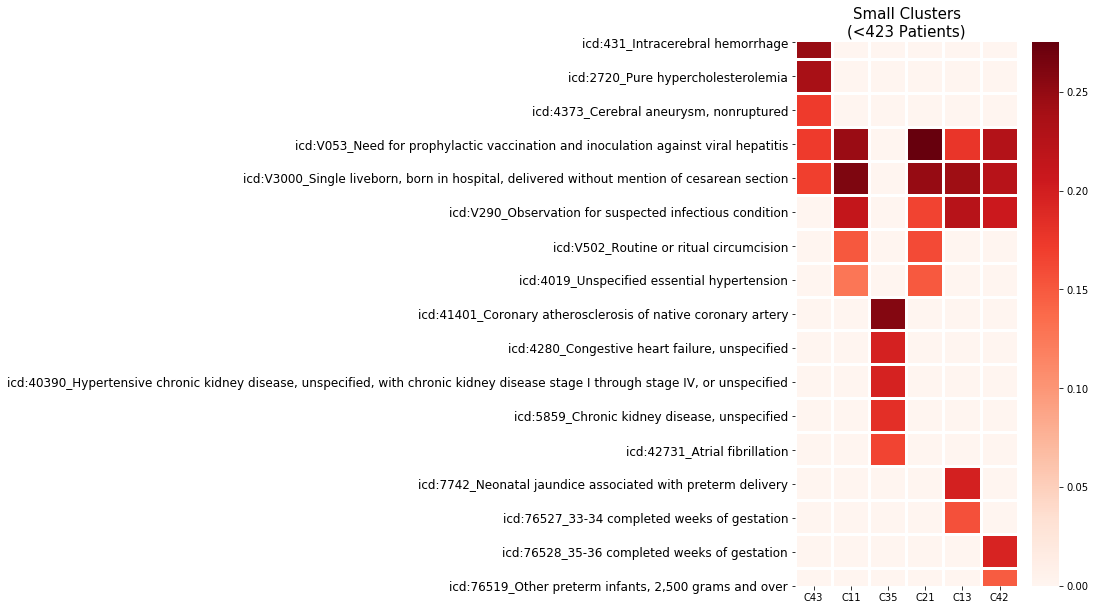

In [208]:
small_clusters = [43, 11, 35, 21, 13, 42]
small_clusters_percentages_df = feats_for_clusters(small_clusters)
heatmap_clusters(small_clusters_percentages_df, title="Small Clusters\n(<423 Patients)")

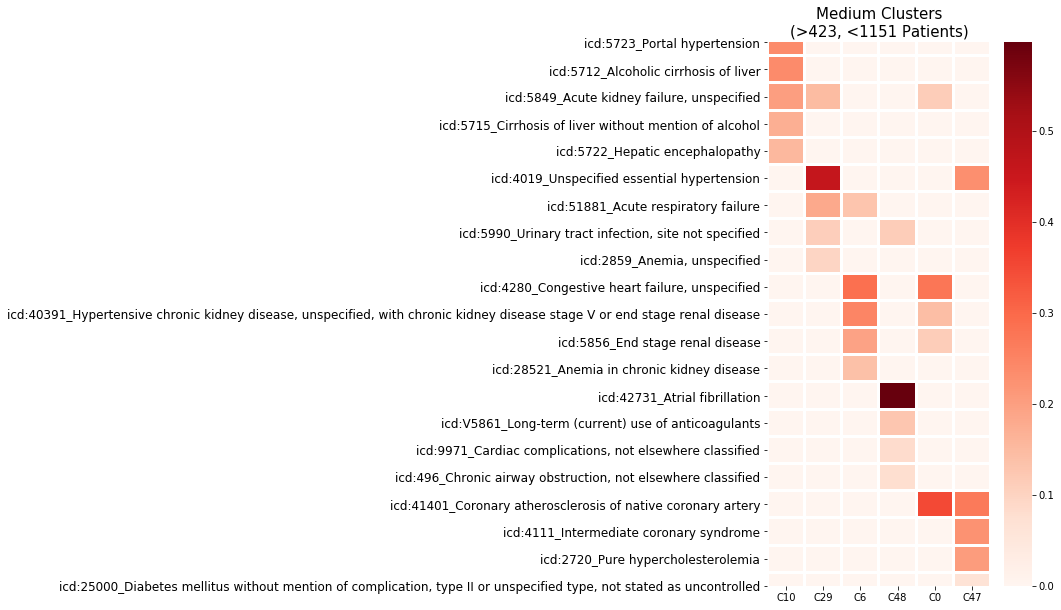

In [209]:
medium_clusters = [10, 29, 6, 48, 0, 47]
medium_clusters_percentages_df = feats_for_clusters(medium_clusters)
heatmap_clusters(medium_clusters_percentages_df, title="Medium Clusters\n(>423, <1151 Patients)")

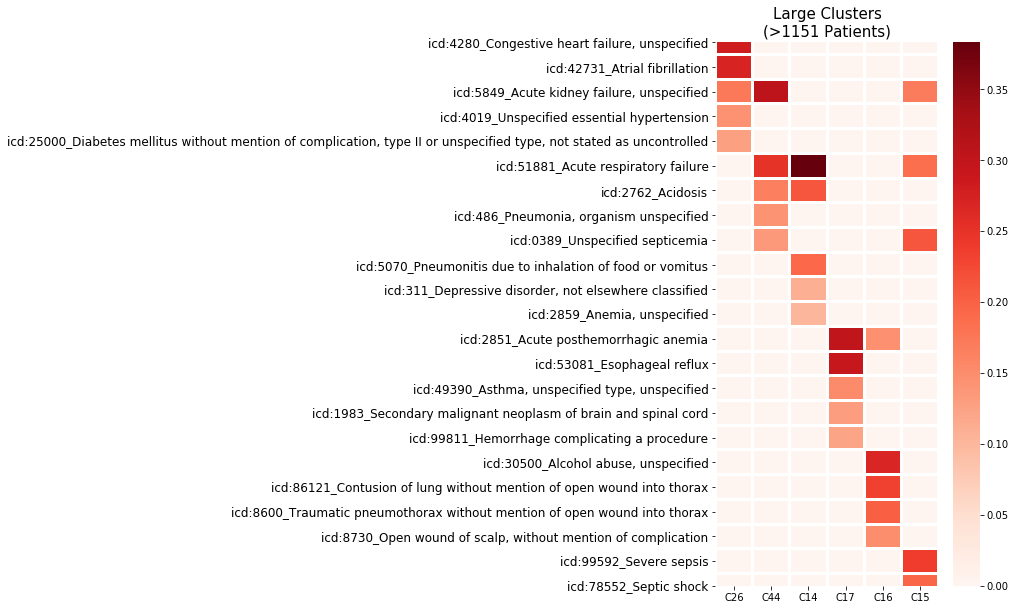

In [214]:
large_clusters = [26, 44, 14, 17, 16, 15]
large_clusters_percentages_df = feats_for_clusters(large_clusters)
heatmap_clusters(large_clusters_percentages_df, title="Large Clusters\n(>1151 Patients)")

In [224]:
#1.Need to show that clusters make sense -> pheCode or mortality analysis
# Current idea is to verify using co-occurence matching across clusters. 
#This is where u look for the number of patients across clusters who share 2 diseases. 
#If your clustering is good, you expect that this number differs across clusters, showing that each cluster captures
#something interesting / you can find a mix between the two.
#This is also beneficial bc it allows you to look at genetic coocurrence as well
#To do this, you need to map relevant ICD codes to pheCodes bc icd codes r too specific. Doctors also use phecodes more
#Then, you need to just to basic counting of patients with 2 classes of diseases and hope that these vary across ur clusters.

In [285]:
def load_phecode_file(file):
    col_names = pd.read_csv(file, nrows=0).columns
    types_dict = {'icd9': str, 'phecode': str}
    types_dict.update({col: str for col in col_names})
    return pd.read_csv(file, dtype=types_dict)

icd_to_phecode = load_phecode_file("phecode_icd9_map_unrolled.csv")
phecode_defs = load_phecode_file("phecode_definitions.csv")

In [284]:
def remove_decimals_from_phecodes(phecode):
    pos = phecode.find(".")
    if pos == -1:
        return phecode
    else:
        shortened_phecode = phecode[:pos]
        #if this shortened phecode does not exist
        if len(phecode_defs[phecode_defs['phecode'] == shortened_phecode]) == 0:
            return phecode
        return shortened_phecode
    
#Remove periods from icd9codes
icd_to_phecode['icd9'] = icd_to_phecode["icd9"].apply(func=lambda x: x.replace(".", ""))

icd_to_phecode_no_decimals = icd_to_phecode.copy()
icd_to_phecode_no_decimals['phecode'] = icd_to_phecode_no_decimals['phecode'].apply(func=remove_decimals_from_phecodes)
icd_to_phecode_no_decimals['phecode'].unique().shape

(545,)

In [295]:
def add_phenotype_names(phecode):
    phenotype = phecode_defs[phecode_defs["phecode"] == phecode]['phenotype'].values[0]
    return phenotype

icd_phecode_name_mapping = icd_to_phecode_no_decimals[icd_to_phecode_no_decimals['icd9'].isin(icd9codes['ICD9_CODE'])]
icd_phecode_name_mapping['phenotype'] = icd_phecode_name_mapping['phecode'].apply(func=add_phenotype_names)

# icd_phecode_name_mapping.to_csv("./data/icd9_phecode_mapping.csv", index=False)

/opt/anaconda3/envs/mengp369/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [299]:
icd_phecode_name_mapping = pd.read_csv('./data/icd9_phecode_mapping.csv', dtype={"phecode":str})

icd_phecode_name_mapping

,icd9,phecode,phenotype
0,0030,008,Intestinal infection
1,0030,008,Intestinal infection
2,0031,038,Septicemia
3,0031,038,Septicemia
4,0038,008,Intestinal infection
...,...,...,...
9524,V8544,278,"Overweight, obesity and other hyperalimentation"
9525,V8545,278,"Overweight, obesity and other hyperalimentation"
9526,V8545,278,"Overweight, obesity and other hyperalimentation"
9527,V8545,278,"Overweight, obesity and other hyperalimentation"


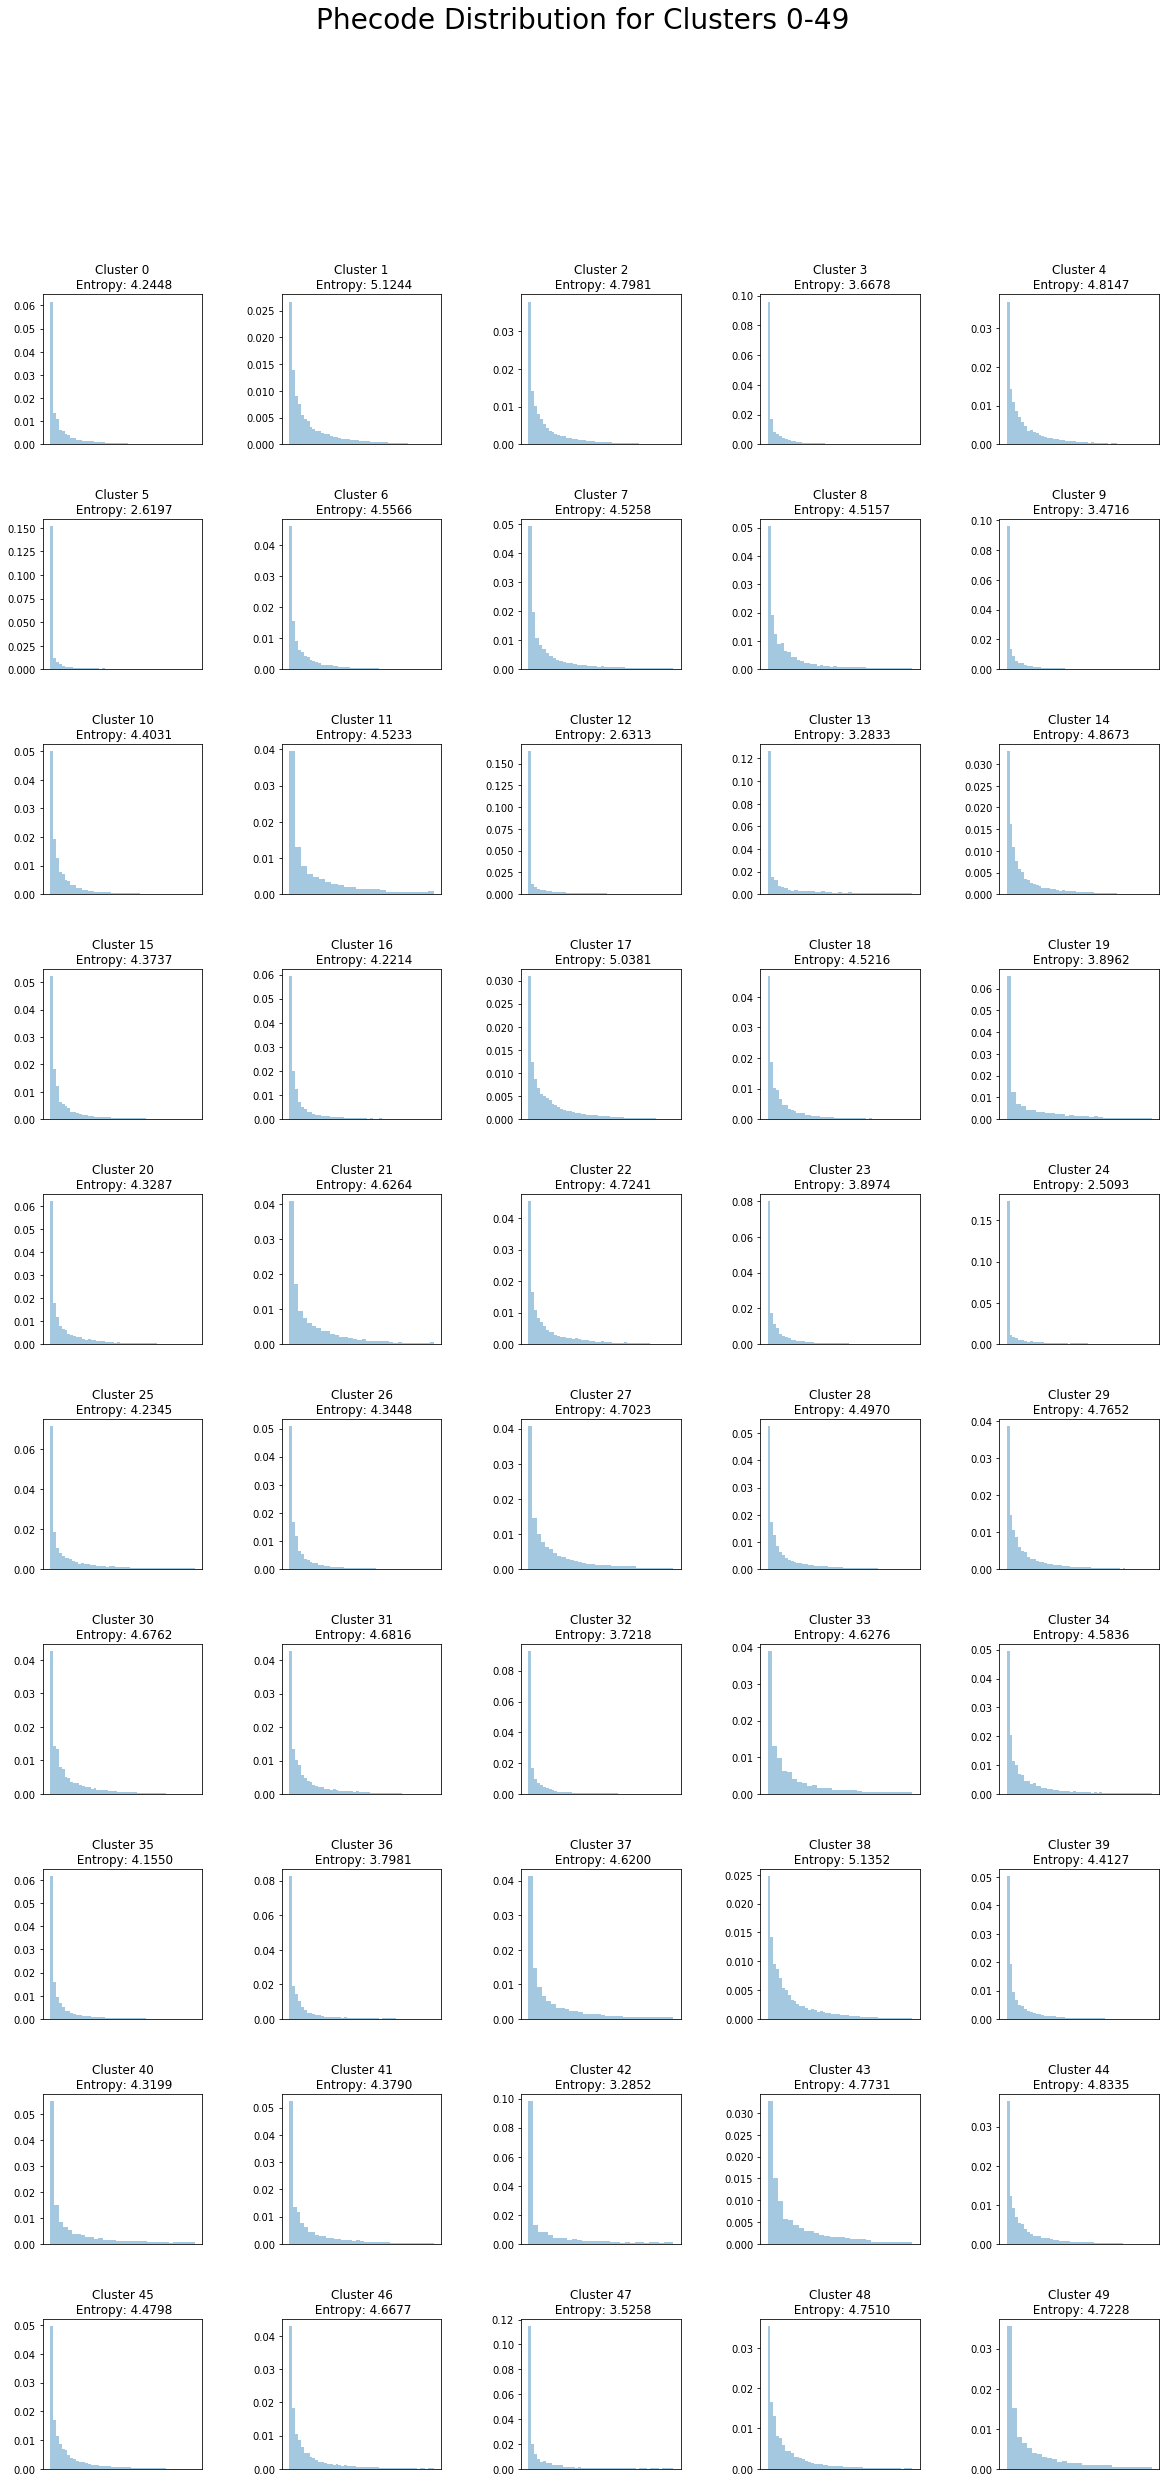

In [371]:
def get_phecode_and_phenotype_from_icd9(icd9):
    
    phecode = icd_phecode_name_mapping[icd_phecode_name_mapping['icd9'] == icd9]['phecode'].values[0]
    phenotype = icd_phecode_name_mapping[icd_phecode_name_mapping['icd9'] == icd9]['phenotype'].values[0]
    return (phecode, phenotype)
#     return {"phecode":phecode, "phenotype":phenotype}

def phecode_distribution_for_cluster_i(cluster_i): 
    pidx_in_cluster_i = cluster_assignments[cluster_assignments["CLUSTER"] == cluster_i]['ORIGINAL_INDEX']
    pfeats_in_cluster_i = patient_icd_binary[pidx_in_cluster_i]
    pfeats_distr_in_cluster_i = np.asarray(pfeats_in_cluster_i.sum(axis=0))

    icd9codes_aslist = icd9codes["ICD9_CODE"].tolist()

    icd_freq_pairs_in_cluster_i = list(zip(icd9codes_aslist, pfeats_distr_in_cluster_i[0]))
    icd_freq_pairs_in_cluster_i = sorted(icd_freq_pairs_in_cluster_i, key=lambda p: p[1], reverse=True)
    icd_freq_pairs_in_cluster_i_nonzeros = [p for p in icd_freq_pairs_in_cluster_i if p[1] > 0]
    icd_freq_pairs_in_cluster_i = icd_freq_pairs_in_cluster_i_nonzeros

    #List[ ((phecode, phenotype), freq) ]
    phecode_phenotype_freq_pairs_in_cluster_i = {}
    for pair in icd_freq_pairs_in_cluster_i:
        icd9 = pair[0]
        freq = pair[1]

        try:
            phecode_phenotype = get_phecode_and_phenotype_from_icd9(icd9)
            
            if phecode_phenotype not in phecode_phenotype_freq_pairs_in_cluster_i:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] = freq
            else:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] += freq
        except:
            pass
        
    return phecode_phenotype_freq_pairs_in_cluster_i

def phecode_dist_from_phecode_freqs(phecode_phenotype_freq_pairs_in_cluster_i):
    phecode_counts = sorted(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1], reverse=True)

    #Make list that is plotable
    phecode_distribution = []
    for idx, pair in enumerate(phecode_counts):
        phecode_frequency = pair[1]
        phecode_distribution += [idx] * phecode_frequency
    return phecode_distribution

def cluster_entropy_from_dist(dist):
    counts = Counter(dist)
    counts = [p[1] for p in counts.most_common()]
    return entropy(counts)
    
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("Phecode Distribution for Clusters 0-49", fontsize=28)

for cluster_i in range(50):
    phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(cluster_i)
    phecode_dist = phecode_dist_from_phecode_freqs(phecode_phenotype_freq_pairs_in_cluster_i)
    
    e = cluster_entropy_from_dist(phecode_dist)
    
    ax_subplot = fig.add_subplot(10, 5, cluster_i + 1)
    ax_subplot.title.set_text("Cluster {}\n Entropy: {:.4f}".format(cluster_i, e))
    ax_sns = sns.distplot(phecode_dist, kde=False, norm_hist=True)
    ax_sns.set_xticks([])
    
plt.savefig("./tests/phecode_dist_k50_NOT_mc.png")

In [375]:
#Cluster 38 has the highest entropy, then Cluster 1
ci = 1
phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(ci)
phecode_dist = phecode_dist_from_phecode_freqs(phecode_phenotype_freq_pairs_in_cluster_i)
e = cluster_entropy_from_dist(phecode_dist)

phecode_counts = sorted(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1], reverse=True)
phecode_counts

[(('276', 'Disorders of fluid, electrolyte, and acid-base balance'), 653),
 (('317', 'Alcohol-related disorders'), 529),
 (('285', 'Other anemias'), 506),
 (('296', 'Mood disorders'), 438),
 (('316', 'Substance addiction and disorders'), 380),
 (('198', 'Secondary malignant neoplasm'), 369),
 (('345', 'Epilepsy, recurrent seizures, convulsions'), 329),
 (('318', 'Tobacco use disorder'), 302),
 (('300', 'Anxiety disorders'), 272),
 (('530', 'Diseases of esophagus'), 271),
 (('480', 'Pneumonia'), 270),
 (('348', 'Other conditions of brain'), 262),
 (('250', 'Diabetes mellitus'), 252),
 (('427', 'Cardiac dysrhythmias'), 250),
 (('244', 'Hypothyroidism'), 229),
 (('495', 'Asthma'), 223),
 (('458', 'Hypotension'), 212),
 (('509', 'Respiratory failure, insufficiency, arrest'), 206),
 (('041', 'Bacterial infection NOS'), 193),
 (('070', 'Viral hepatitis'), 190),
 (('433', 'Cerebrovascular disease'), 162),
 (('819', 'Skull and face fracture and other intercranial injury'), 155),
 (('496', 'Chr

In [ ]:
top_phecodes = []
for ci in range(50):
    phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(1)
    most_common_phecode = max(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1])
    top_phecodes.append(most_common_phecode)

In [ ]:
top_phecodes